In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

/Users/georgeoblapenko/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [60]:
rate, data = wavfile.read('01-18_Pulses.wav')

In [61]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    wavfile.write(name, s_r, a_s)

In [62]:
def write_mono(a_m, s_r, name):
    write_stereo(a_m, a_m, s_r, name)

In [63]:
max_val = 30000  # if a sample's value is larger than this, we set it to max_val

In [64]:
np.max(np.abs(data[:,0])), np.max(np.abs(data[1:,0] - data[:-1,0]))

(21963, 3175)

In [65]:
wav_data = data[:, 0]

In [88]:
offs = 3 * rate
n_data = 5000
prev_samples = 10000
add_features = [0]

prev_time_energy_amt = 0
prev_time_energy_length = 500

add_features.append(prev_time_energy_amt)

start_sample = max(prev_samples, prev_time_energy_amt * prev_time_energy_length)

In [89]:
feature_arr = np.zeros([n_data, prev_samples + sum(add_features)])
target_arr = np.zeros([n_data])

In [90]:
for i in range(n_data):
    feature_arr[i, :prev_samples] = wav_data[offs + start_sample + i - prev_samples:offs + start_sample + i]
    
    for j in range(add_features[0]):
        feature_arr[i, prev_samples+j] = np.sum(np.abs(wav_data[offs + start_sample
                                                                + i - prev_time_energy_length*(j+1):
                                                                offs + start_sample
                                                                + i - prev_time_energy_length*j]))
    
    target_arr[i] = wav_data[offs + start_sample + i]

In [91]:
feat_scaler = StandardScaler()
feature_arr = feat_scaler.fit_transform(feature_arr)
t_mean, t_std = np.mean(target_arr), np.std(target_arr)
target_arr = (target_arr - t_mean) / t_std
max_val = (max_val - t_mean) / t_std

In [92]:
# predictor = XGBRegressor()
predictor = LinearRegression()
predictor.fit(feature_arr, target_arr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
generate_size = 50000
start_pos = start_sample + n_data  # we take a chunk of the original audio starting from this position to 'seed'
min_seed_size = max(prev_samples, prev_time_energy_amt * prev_time_energy_length)
new_audio = np.zeros(generate_size + min_seed_size)
new_audio[:min_seed_size] = wav_data[offs + start_pos:offs + start_pos + min_seed_size]

gen_feat_arr = np.zeros([1, feature_arr.shape[1]])

In [94]:
for i in range(generate_size):
    gen_feat_arr[0, :prev_samples] = new_audio[min_seed_size + i-prev_samples:min_seed_size + i]
    for j in range(add_features[0]):
        gen_feat_arr[0, prev_samples+j] = np.sum(np.abs(new_audio[min_seed_size + i - prev_time_energy_length*(j+1):
                                                                  min_seed_size + i - prev_time_energy_length*j]))
    
    new_sample = predictor.predict(feat_scaler.transform(gen_feat_arr))
    if new_sample > max_val:
        new_sample = max_val
    elif new_sample < -max_val:
        new_sample = -max_val

    new_audio[min_seed_size + i] = new_sample * t_std + t_mean

In [95]:
mean_squared_error(wav_data[start_pos + min_seed_size:start_pos + min_seed_size + generate_size],
                   new_audio[min_seed_size:])

418517.09622704453

on 50k samples:

5k data, 5k len, 0 amt of 500 len energy 154224
5k data, 5k len, 10 amt of 500 len energy 896409797

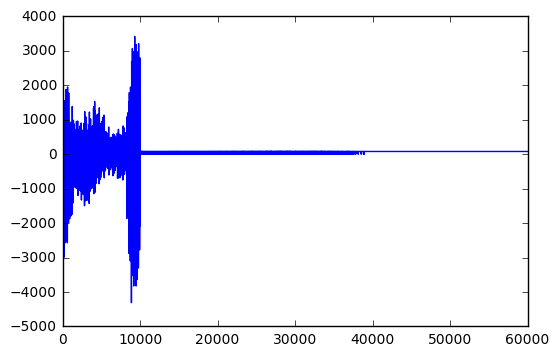

In [96]:
plt.plot(new_audio)

In [87]:
write_mono(new_audio, rate, 'Pulses-test.wav')